<a href="https://colab.research.google.com/github/tomonoshin-lab/fl-consortium-incentive-study/blob/main/Copy_of_20250712_ver_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. ディレクトリと__init__.py作成

In [ ]:
%%bash
mkdir -p model analysis
touch model/__init__.py analysis/__init__.py



2. config.py

In [ ]:

%%writefile config.py
import numpy as np

PARAMS = {
    'NUM_COMPANIES'    : 100,
    'TURNS'            : 100,
    'INVITE_NUM'       : 25,
    'COLLISIONS'       : 0,
    'NEW_ENTRIES'      : 25,
    'MAX_AGE'          : 40,
    'CONSORTIUM_COEF'  : 0.30,
    'NON_CONS_r'       : 0.15,
    'alpha_con'        : 500,
    'alpha_non'        : 500,
    'DISTRIBUTION_MODE': 0.0,
    'INERTIA_STATIC'   : 1.0,   # 静的要因 σ₀
    'INERTIA_DYNAMIC'  : 0.1,   # 動的要因 σ₁（在籍年数係数）
}
SNAPSHOT_TURN = PARAMS['TURNS']
RUNS = 100
MODES = np.arange(0,1.01,0.2)


Overwriting config.py


3. model/helpers.py

In [ ]:
%%writefile model/helpers.py
import numpy as np
from config import PARAMS

def consortium_return_avg(avg_size, params=PARAMS):
    c, a = params['CONSORTIUM_COEF'], params['alpha_con']
    return avg_size*c/(1+(avg_size/a)**2)

def consortium_total_profit(sizes_in, params=PARAMS):
    if sizes_in.size==0: return 0.0
    return consortium_return_avg(sizes_in.mean(),params)*sizes_in.size

def non_cons_growth(sizes_out, params=PARAMS):
    r,a = params['NON_CONS_r'], params['alpha_non']
    return sizes_out * r/(1+(sizes_out/a)**2)

def p_join_equal(sizes_in, size, params=PARAMS):
    avg = sizes_in.mean() if sizes_in.size>0 else 0.0
    c,a,r,an = (params['CONSORTIUM_COEF'], params['alpha_con'],
                params['NON_CONS_r'], params['alpha_non'])
    cb = consortium_return_avg(avg,params)
    nb = non_cons_growth(size,params)
    return cb/(cb+nb) if (cb+nb)>0 else 0.0

def p_join_profit(sizes_in, size, params=PARAMS):
    tot = consortium_total_profit(sizes_in,params)
    ssum= sizes_in.sum()
    share = tot*size/ssum if ssum>0 else 0.0
    nb = non_cons_growth(size,params)
    return share/(share+nb) if (share+nb)>0 else 0.0

def death_probs(ages):
    probs = np.empty_like(ages, dtype=float)
    probs[ages<=10] = 1/15
    probs[(ages>10)&(ages<=20)] = 1/20
    probs[(ages>20)&(ages<=30)] = 1/15
    probs[(ages>30)&(ages<=40)] = 1/10
    probs[ages>40] = 1/5
    return probs


Overwriting model/helpers.py


4. model/simulator.py

In [ ]:
%%writefile model/simulator.py
import numpy as np
from config import PARAMS, SNAPSHOT_TURN
from model.helpers import (
    consortium_return_avg,
    consortium_total_profit,
    non_cons_growth,
    p_join_equal,
    p_join_profit,
    death_probs
)

def p_profit_based(sizes_in, size, mode, params=PARAMS):
    """加入/脱退の利益比較（mode=0:平均分配, mode=1:利益シェア, 混合も可）"""
    p_eq = p_join_equal(sizes_in, size, params)
    p_pf = p_join_profit(sizes_in, size, params)
    return (1 - mode) * p_eq + mode * p_pf

def run_simulation_np(record_snapshots=False, snapshot_turns=None):
    N = PARAMS['NUM_COMPANIES']
    sizes = np.arange(1, N + 1, dtype=float)
    np.random.shuffle(sizes)
    ages0 = np.clip(np.random.normal(20, 5, N).astype(int), 0, PARAMS['MAX_AGE'])
    birth = -ages0.copy()
    in_cons = np.zeros(N, bool)
    in_cons[np.random.choice(N, PARAMS['INVITE_NUM'], replace=False)] = True

    ts = np.zeros((PARAMS['TURNS'] + 1, 4))
    snapshots = {} if record_snapshots else None

    sigma0 = PARAMS.get('INERTIA_STATIC', 0.0)
    sigma1 = PARAMS.get('INERTIA_DYNAMIC', 0.0)

    for t in range(PARAMS['TURNS'] + 1):
        n_cons = in_cons.sum()
        s_cons = sizes[in_cons].sum()
        n_non = in_cons.size - n_cons
        s_non = sizes[~in_cons].sum()
        ts[t] = [n_cons, s_cons, n_non, s_non]

        if record_snapshots and snapshot_turns and t in snapshot_turns:
            snapshots[t] = {'sizes': sizes.copy(), 'in_cons': in_cons.copy()}

        if t == PARAMS['TURNS']:
            break

        x = PARAMS['DISTRIBUTION_MODE']
        outsiders = np.where(~in_cons)[0]
        k = min(PARAMS['INVITE_NUM'], outsiders.size)
        pick = np.random.choice(outsiders, k, replace=False)
        sin = sizes[in_cons]
        # --- 加入判定 ---
        for i in pick:
            p = p_profit_based(sin, sizes[i], x)  # 利益比較ベース
            if np.random.rand() < p:
                in_cons[i] = True

        sin = sizes[in_cons]
        idxs = np.where(in_cons)[0]
        tenures = (t - birth[idxs])  # 在籍年数
        # --- 脱退判定 ---
        for idx, i in enumerate(idxs):
            p = p_profit_based(sin, sizes[i], x)  # 利益比較ベース（加入と同式）
            tenure = tenures[idx]
            # 修正：利益が高いほど残留意向が高い（1-p）
            p_leave = (1 - p) / (1 + sigma0 + sigma1 * tenure)
            if np.random.rand() < p_leave:
                in_cons[i] = False

        n = sizes.size
        m = min(PARAMS['COLLISIONS'], n // 2)
        a = np.random.randint(0, n, m)
        b = np.random.randint(0, n, m)
        sa, sb = sizes[a], sizes[b]
        rm = np.zeros(n, bool)
        mask_a = sa < sb
        mask_b = sb < sa
        rm[a[mask_a]] = True
        rm[b[mask_b]] = True
        eq = sa == sb
        rm[a[eq]] = True
        rm[b[eq]] = True
        keep = ~rm
        sizes = sizes[keep]
        in_cons = in_cons[keep]
        birth = birth[keep]

        ne = PARAMS['NEW_ENTRIES']
        sizes = np.concatenate([sizes, np.random.randint(1, 101, ne)])
        in_cons = np.concatenate([in_cons, np.zeros(ne, bool)])
        birth = np.concatenate([birth, np.full(ne, t)])

        sin = sizes[in_cons]
        avg = sin.mean() if sin.size > 0 else 0.0
        totp = consortium_total_profit(sin)
        tot_s = sin.sum()
        growth_non = non_cons_growth(sizes[~in_cons])
        share = totp * sizes[in_cons] / tot_s if tot_s > 0 else 0.0
        growth_con = (1 - x) * consortium_return_avg(avg) + x * share
        sizes[~in_cons] += growth_non
        sizes[in_cons] += growth_con

        ages = t - birth
        probs = death_probs(ages)
        keep = np.random.rand(sizes.size) >= probs
        sizes = sizes[keep]
        in_cons = in_cons[keep]
        birth = birth[keep]

    return (ts, snapshots) if record_snapshots else ts

# エイリアス
run_simulation = run_simulation_np



Overwriting model/simulator.py


5. analysis/gini.py

In [ ]:
%%writefile analysis/gini.py
import numpy as np

def gini_coefficient(x):
    x = np.asarray(x, float)
    if x.size==0: return np.nan
    sx = np.sort(x); n=sx.size; idx=np.arange(1,n+1)
    return 2*(idx*sx).sum()/(n*sx.sum()) - (n+1)/n


Overwriting analysis/gini.py


6. analysis/visualize.py

In [ ]:
%%writefile analysis/visualize.py
import matplotlib.pyplot as plt
import numpy as np
from config import PARAMS, SNAPSHOT_TURN, RUNS, MODES
from model.simulator import run_simulation
from analysis.gini import gini_coefficient

def compute_time_series(mode, return_size_sum=False):
    PARAMS['DISTRIBUTION_MODE'] = mode
    res = [run_simulation() for _ in range(RUNS)]
    agg = np.sum(res, axis=0)/RUNS
    if return_size_sum:
        return agg[:,1], agg[:,3]  # consortium total size, non-consortium total size
    else:
        return agg[:,0], agg[:,2]  # consortium firm count, non-consortium firm count

def plot_time_series(turns, mode_data_cons, mode_data_non, title, ylabel):
    plt.figure(figsize=(10,7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(MODES)))
    lines = []
    labels = []
    for i, mode in enumerate(MODES):
        # 実線: Consortium, 破線: Non-Consortium, 色は揃える
        line1, = plt.plot(turns, mode_data_cons[i], '-', color=colors[i], label=f"{mode:.1f} Con")
        line2, = plt.plot(turns, mode_data_non[i], '--', color=colors[i], label=f"{mode:.1f} Non-Con")
        lines.append(line1)
        lines.append(line2)
        labels.append(f"{mode:.1f} Con")
        labels.append(f"{mode:.1f} Non-Con")
    plt.xlabel('Turn'); plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(lines, labels, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()




def plot_gini_coefficients(runs: int = RUNS, modes: np.ndarray = MODES):
    from analysis.gini import gini_coefficient

    results = {
        'mode': [],
        'all': [],
        'cons': [],
        'non': [],
    }

    for mode in modes:
        PARAMS['DISTRIBUTION_MODE'] = mode

        gini_all_list = []
        gini_cons_list = []
        gini_non_list = []

        for _ in range(runs):
            _, snaps = run_simulation(record_snapshots=True, snapshot_turns=[SNAPSHOT_TURN])
            data = snaps[SNAPSHOT_TURN]
            sizes   = data['sizes']
            in_cons = data['in_cons']

            if len(sizes) == 0:
                continue  # skip empty

            gini_all_list.append(gini_coefficient(sizes))
            if np.any(in_cons):
                gini_cons_list.append(gini_coefficient(sizes[in_cons]))
            else:
                gini_cons_list.append(np.nan)
            if np.any(~in_cons):
                gini_non_list.append(gini_coefficient(sizes[~in_cons]))
            else:
                gini_non_list.append(np.nan)

        results['mode'].append(mode)
        results['all'].append(np.nanmean(gini_all_list))
        results['cons'].append(np.nanmean(gini_cons_list))
        results['non'].append(np.nanmean(gini_non_list))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(results['mode'], results['all'], '-o', label="All Firms")
    plt.plot(results['mode'], results['cons'], '-o', label="Consortium Firms")
    plt.plot(results['mode'], results['non'], '-o', label="Non-Consortium Firms")
    plt.xlabel('Mode')
    plt.ylabel('Gini Coefficient')
    plt.title('Gini Coefficient of Firm Sizes by Mode')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 表としても表示
    import pandas as pd
    df = pd.DataFrame(results)
    display(df)


def plot_avg_size_histograms(
    runs: int = RUNS, modes: np.ndarray = MODES, bins: int = 20):
    """
    各モードごとに最終ターンの「全企業」「コンソーシアム所属」「非所属」サイズ分布の
    RUNS回平均ヒストグラムをプロット
    （X軸0-1000, 50刻みのbin、Y軸0-150, 10刻み）。
    平均値・最頻値・標準偏差も表示。
    """
    bin_edges = np.arange(0, 1001, 50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for mode in modes:
        PARAMS['DISTRIBUTION_MODE'] = mode

        all_sizes_runs = []
        cons_sizes_runs = []
        non_sizes_runs = []

        for _ in range(runs):
            _, snaps = run_simulation(record_snapshots=True, snapshot_turns=[SNAPSHOT_TURN])
            data = snaps[SNAPSHOT_TURN]
            sizes = data['sizes']
            in_cons = data['in_cons']

            all_sizes_runs.append(sizes)
            cons_sizes_runs.append(sizes[in_cons])
            non_sizes_runs.append(sizes[~in_cons])

        all_sizes_concat = np.concatenate(all_sizes_runs)
        cons_sizes_concat = np.concatenate(cons_sizes_runs)
        non_sizes_concat = np.concatenate(non_sizes_runs)

        hist_all, _ = np.histogram(all_sizes_concat, bins=bin_edges)
        hist_cons, _ = np.histogram(cons_sizes_concat, bins=bin_edges)
        hist_non, _ = np.histogram(non_sizes_concat, bins=bin_edges)

        # RUNSで割って平均化
        avg_hist_all = hist_all / runs
        avg_hist_cons = hist_cons / runs
        avg_hist_non = hist_non / runs

        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        bar_params = dict(width=bin_edges[1] - bin_edges[0], align='center')

        stats = [
            (all_sizes_concat, avg_hist_all, 'All Firms', axes[0], 'tab:blue'),
            (cons_sizes_concat, avg_hist_cons, 'Consortium Firms', axes[1], 'tab:green'),
            (non_sizes_concat, avg_hist_non, 'Non-Consortium Firms', axes[2], 'tab:orange')
        ]

        for values, avg_hist, title, ax, color in stats:
            ax.bar(bin_centers, avg_hist, color=color, **bar_params, alpha=0.8)
            ax.set(title=f"Mode={mode:.1f} {title}", xlabel="Size")
            ax.set_xlim(0, 1000)
            ax.set_xticks(np.arange(0, 1001, 100))
            ax.set_ylim(0, 150)
            ax.set_yticks(np.arange(0, 151, 10))
            mean_val = np.mean(values) if len(values) > 0 else np.nan
            std_val = np.std(values) if len(values) > 0 else np.nan
            # 最頻値はbinの中央値で最大カウントのbin
            if avg_hist.sum() > 0:
                mode_val = bin_centers[np.argmax(avg_hist)]
            else:
                mode_val = np.nan
            # テキストで表示
            stats_text = f"Mean: {mean_val:.1f}\nMode: {mode_val:.1f}\nStd: {std_val:.1f}"
            ax.text(0.98, 0.95, stats_text, ha='right', va='top',
                    transform=ax.transAxes, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        axes[0].set_ylabel("Average Number of Firms")
        plt.tight_layout()
        plt.show()


def plot_size_histograms_all_runs_fixed_axes(
    runs: int = RUNS, modes: np.ndarray = MODES):
    """
    各modeごとに、全RUNSのターン100時点のヒストグラムを重ねて描画し、
    平均分布も太線で示す。軸はx:0-1000(50刻み), y:0-150(10刻み)で統一。
    平均値・最頻値・標準偏差も表示。
    """
    bin_edges = np.arange(0, 1001, 50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    for mode in modes:
        PARAMS['DISTRIBUTION_MODE'] = mode

        all_hist_list = []
        cons_hist_list = []
        non_hist_list = []
        all_values = []
        cons_values = []
        non_values = []

        for _ in range(runs):
            _, snaps = run_simulation(record_snapshots=True, snapshot_turns=[SNAPSHOT_TURN])
            data = snaps[SNAPSHOT_TURN]
            sizes = data['sizes']
            in_cons = data['in_cons']

            hist_all, _ = np.histogram(sizes, bins=bin_edges)
            hist_cons, _ = np.histogram(sizes[in_cons], bins=bin_edges)
            hist_non, _ = np.histogram(sizes[~in_cons], bins=bin_edges)

            all_hist_list.append(hist_all)
            cons_hist_list.append(hist_cons)
            non_hist_list.append(hist_non)

            all_values.append(sizes)
            cons_values.append(sizes[in_cons])
            non_values.append(sizes[~in_cons])

        mean_all = np.mean(all_hist_list, axis=0)
        mean_cons = np.mean(cons_hist_list, axis=0)
        mean_non = np.mean(non_hist_list, axis=0)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        bar_params = dict(width=bin_edges[1] - bin_edges[0], align='center')

        stats = [
            (all_hist_list, mean_all, np.concatenate(all_values), 'All Firms', axes[0], 'tab:blue'),
            (cons_hist_list, mean_cons, np.concatenate(cons_values), 'Consortium Firms', axes[1], 'tab:green'),
            (non_hist_list, mean_non, np.concatenate(non_values), 'Non-Consortium Firms', axes[2], 'tab:orange')
        ]

        for hists, avg_hist, values, title, ax, color in stats:
            for h in hists:
                ax.bar(bin_centers, h, color=color, **bar_params, alpha=0.12)
            ax.bar(bin_centers, avg_hist, color=color, **bar_params, alpha=0.8, label='Average')
            ax.set(title=f"Mode={mode:.1f} {title}", xlabel="Size")
            ax.set_xlim(0, 1000)
            ax.set_xticks(np.arange(0, 1001, 100))
            ax.set_ylim(0, 150)
            ax.set_yticks(np.arange(0, 151, 10))
            mean_val = np.mean(values) if len(values) > 0 else np.nan
            std_val = np.std(values) if len(values) > 0 else np.nan
            if avg_hist.sum() > 0:
                mode_val = bin_centers[np.argmax(avg_hist)]
            else:
                mode_val = np.nan
            stats_text = f"Mean: {mean_val:.1f}\nMode: {mode_val:.1f}\nStd: {std_val:.1f}"
            ax.text(0.98, 0.95, stats_text, ha='right', va='top',
                    transform=ax.transAxes, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
            ax.legend()

        axes[0].set_ylabel("Number of Firms")
        plt.tight_layout()
        plt.show()


Overwriting analysis/visualize.py


7. sys.path & モジュールキャッシュクリア

In [ ]:
import sys, os
sys.path.insert(0, os.getcwd())

for mod in ['config', 'model.helpers', 'model.simulator', 'analysis.gini', 'analysis.visualize']:
    if mod in sys.modules:
        del sys.modules[mod]


8. 動作確認

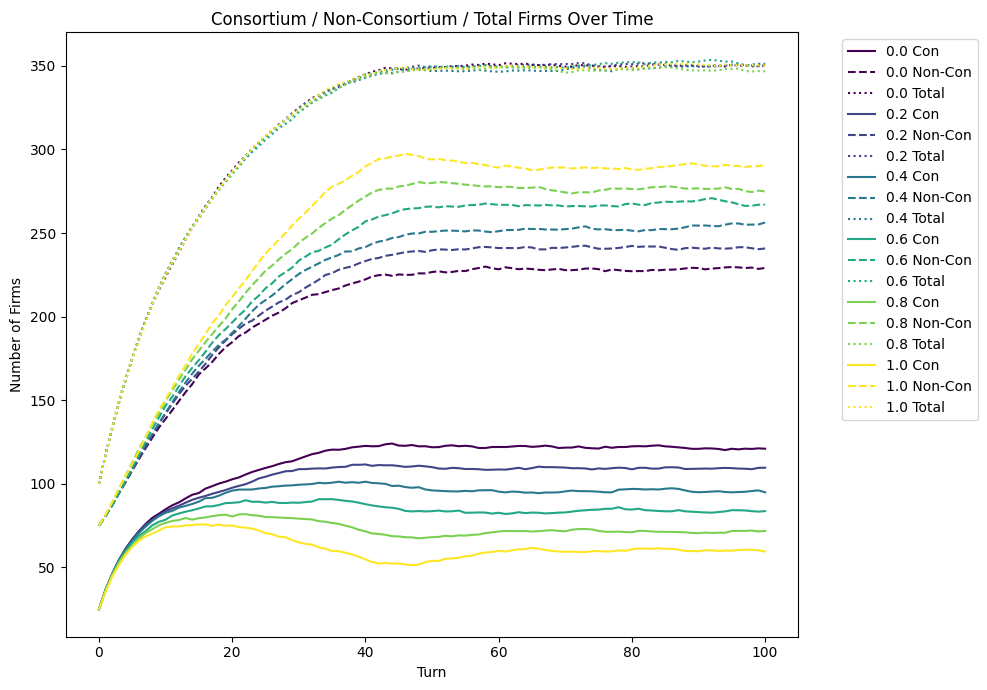

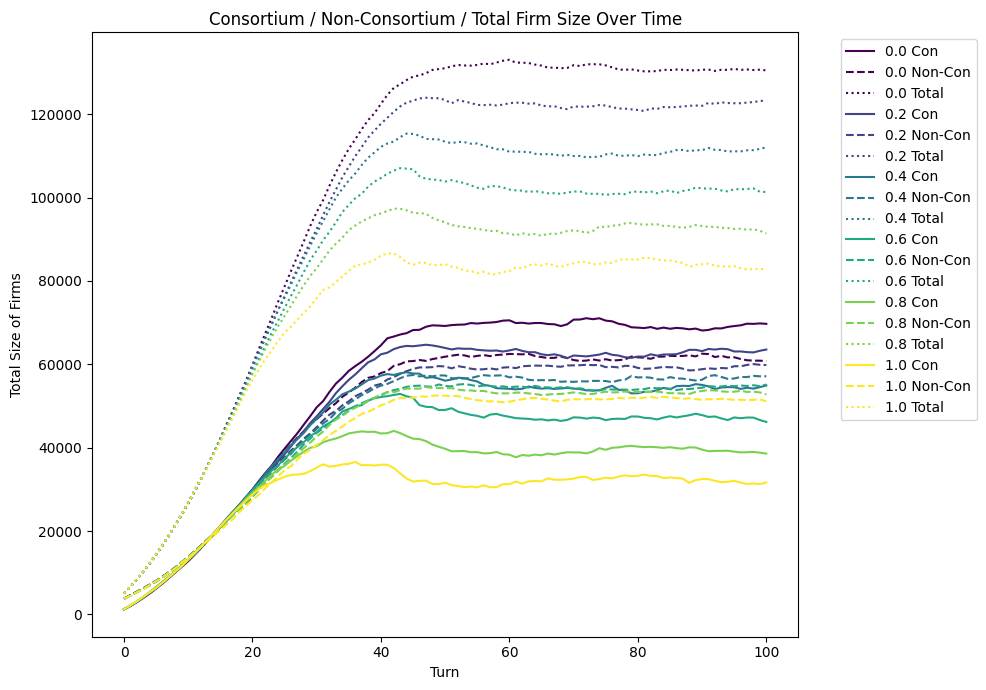

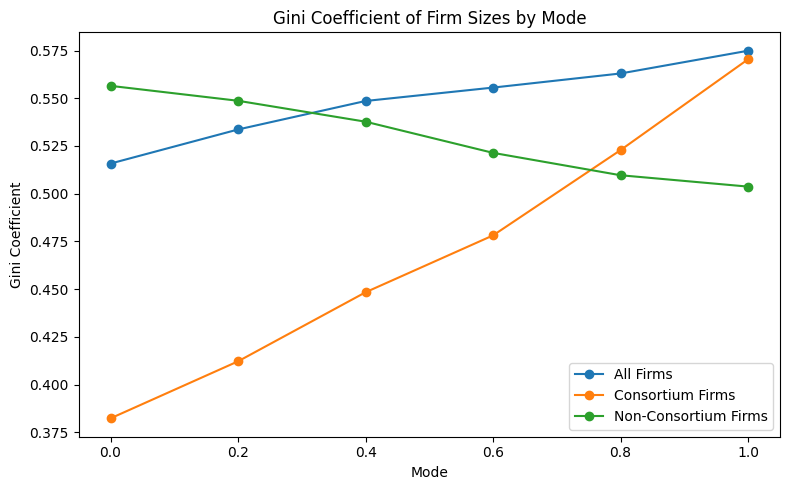

,mode,all,cons,non
0,0.0,0.515796,0.382322,0.556503
1,0.2,0.533644,0.412192,0.548684
2,0.4,0.548575,0.448366,0.537720
3,0.6,0.555597,0.478167,0.521392
4,0.8,0.562987,0.522864,0.509667
5,1.0,0.574908,0.570436,0.503718


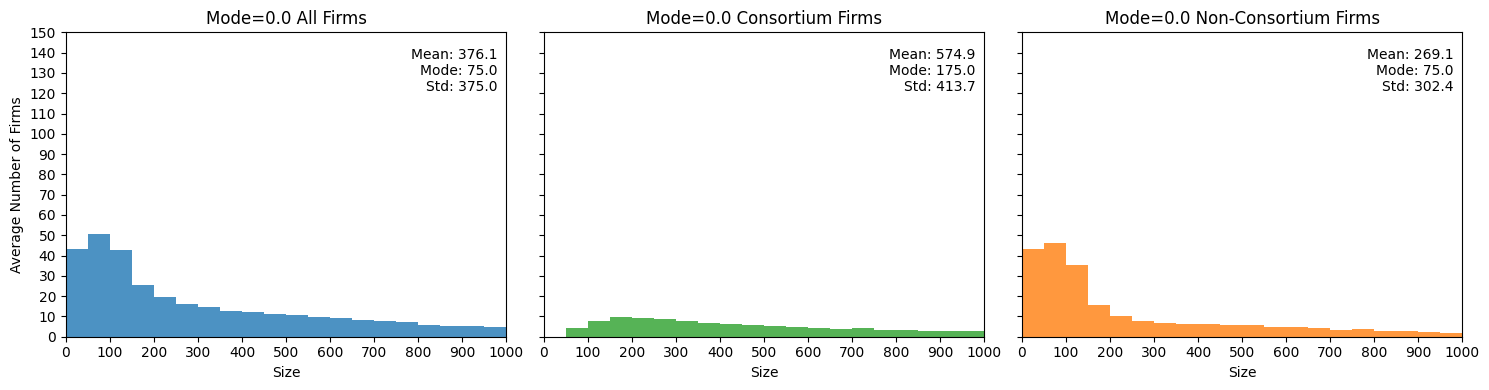

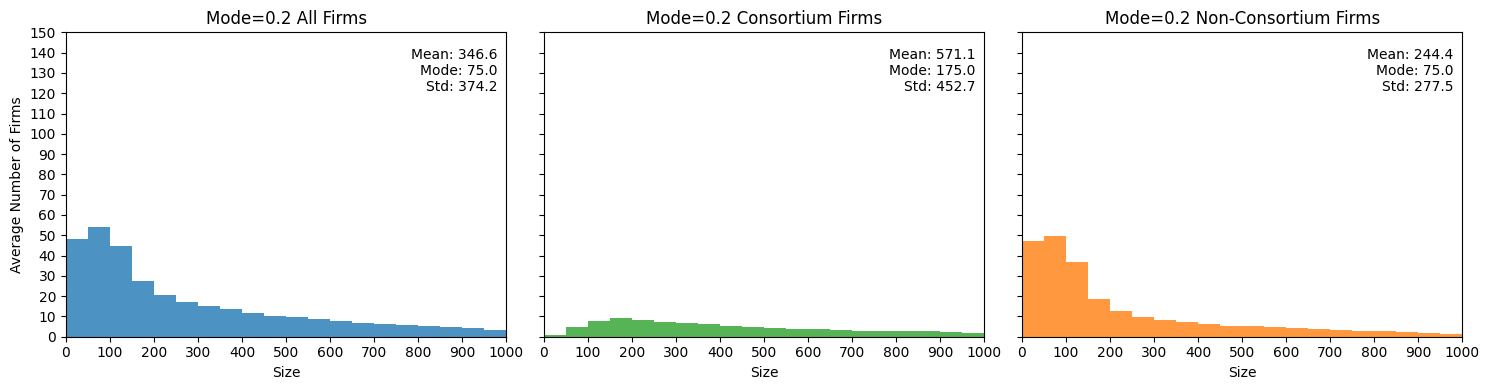

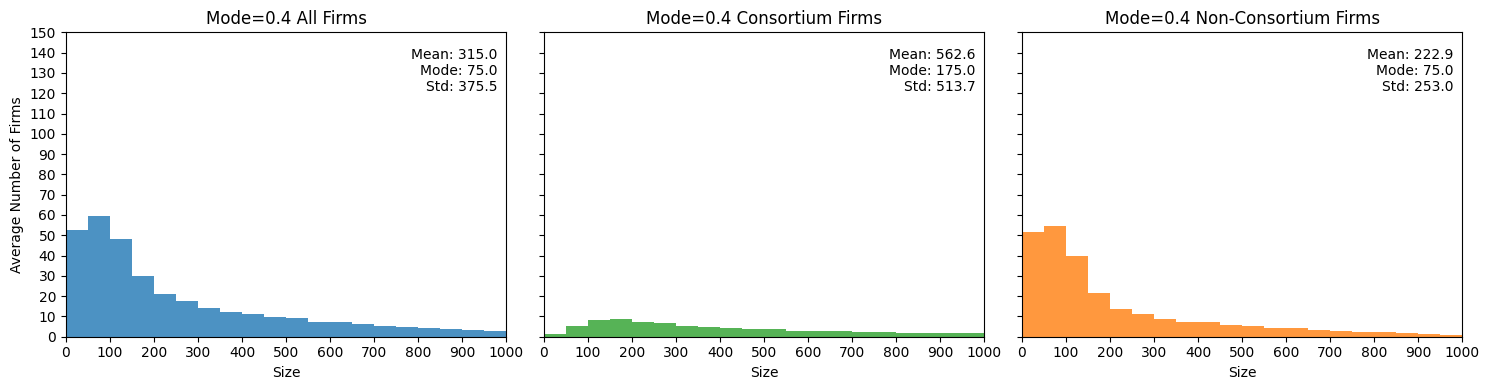

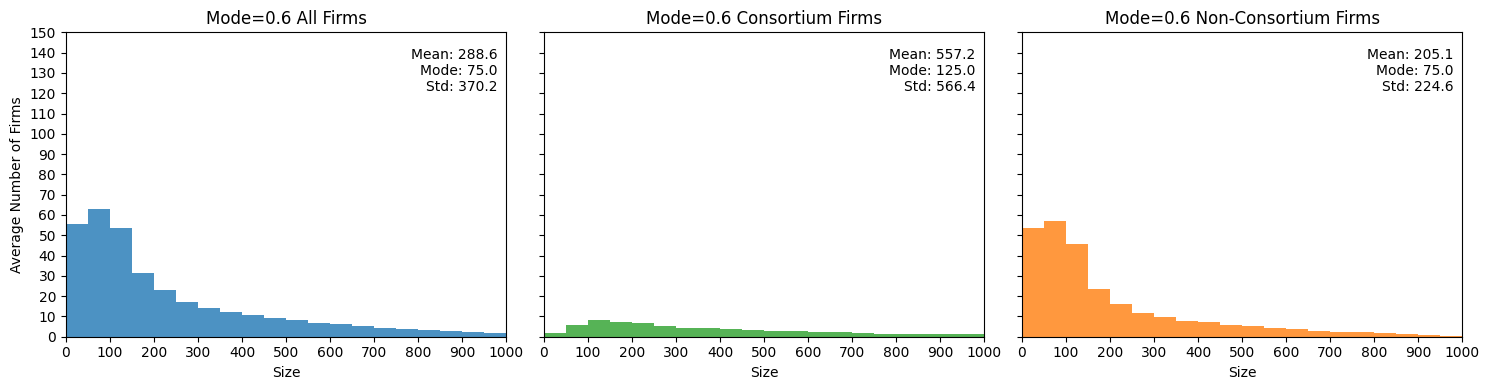

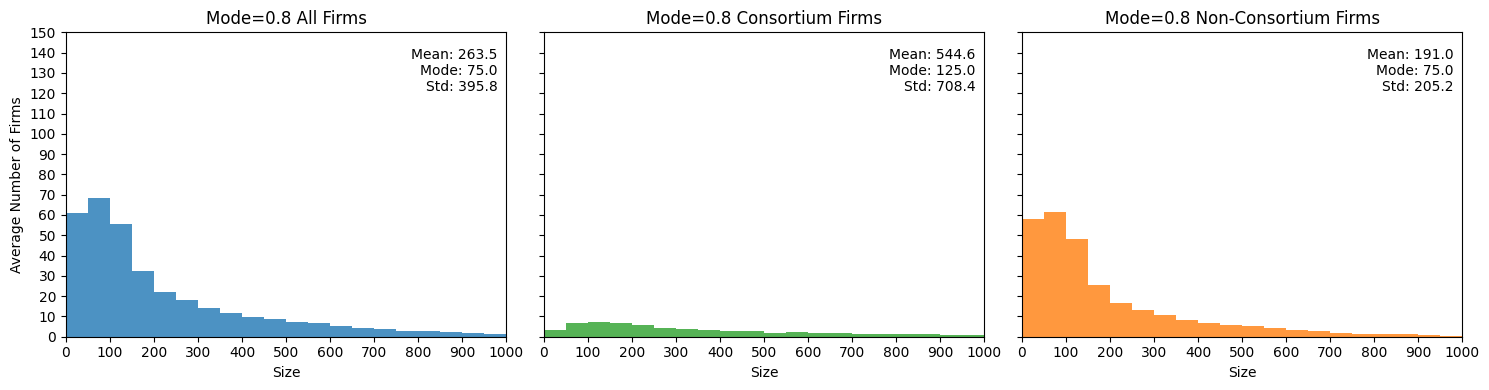

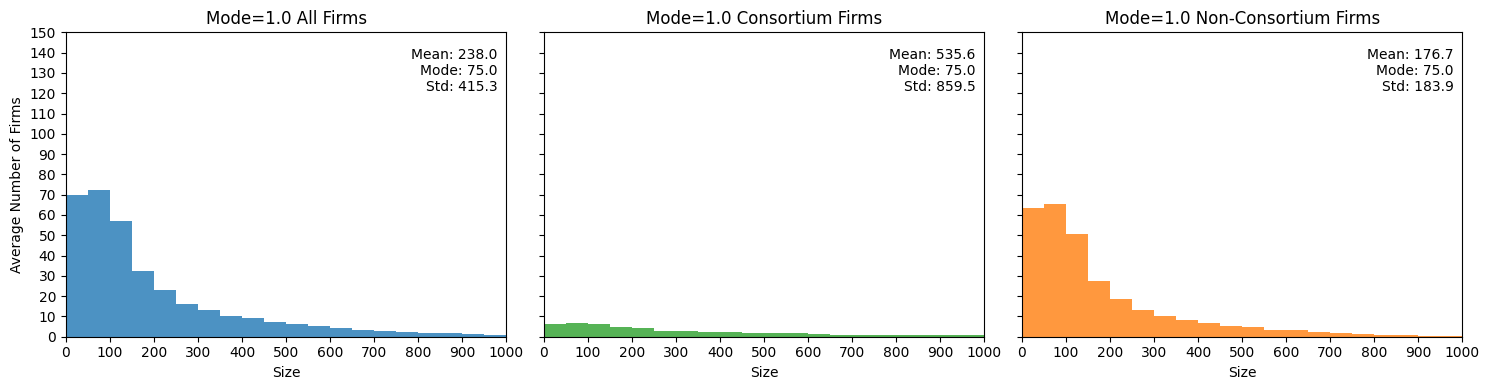

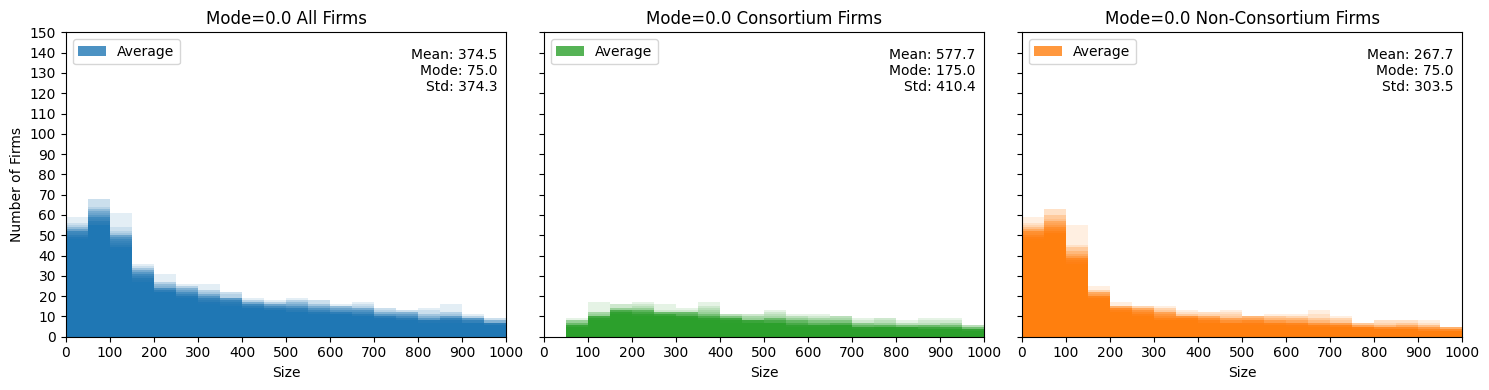

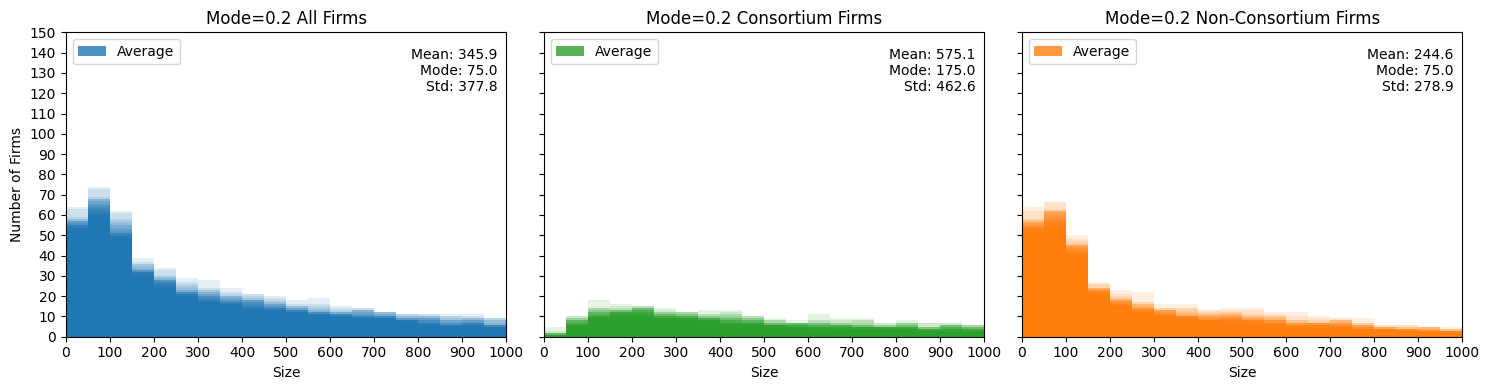

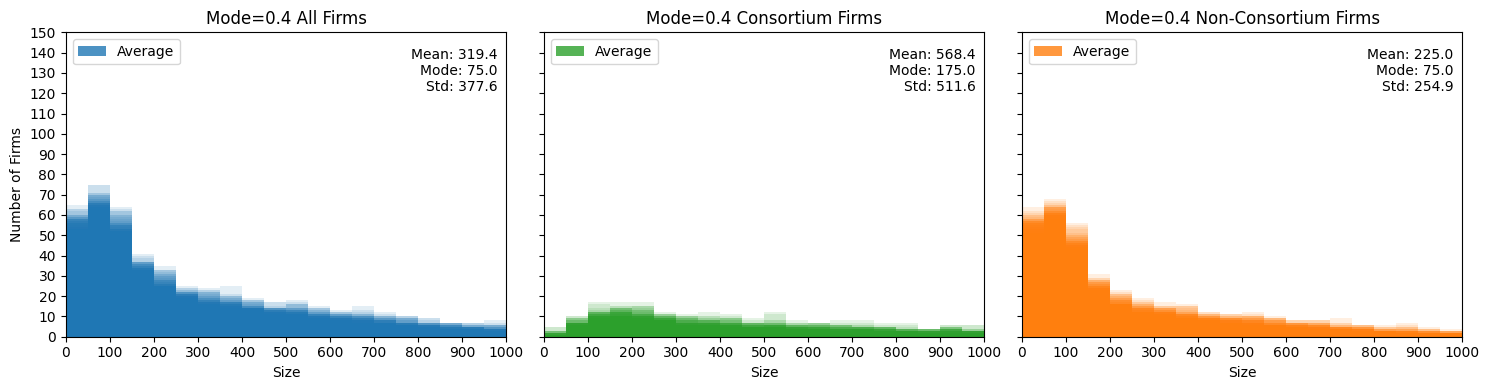

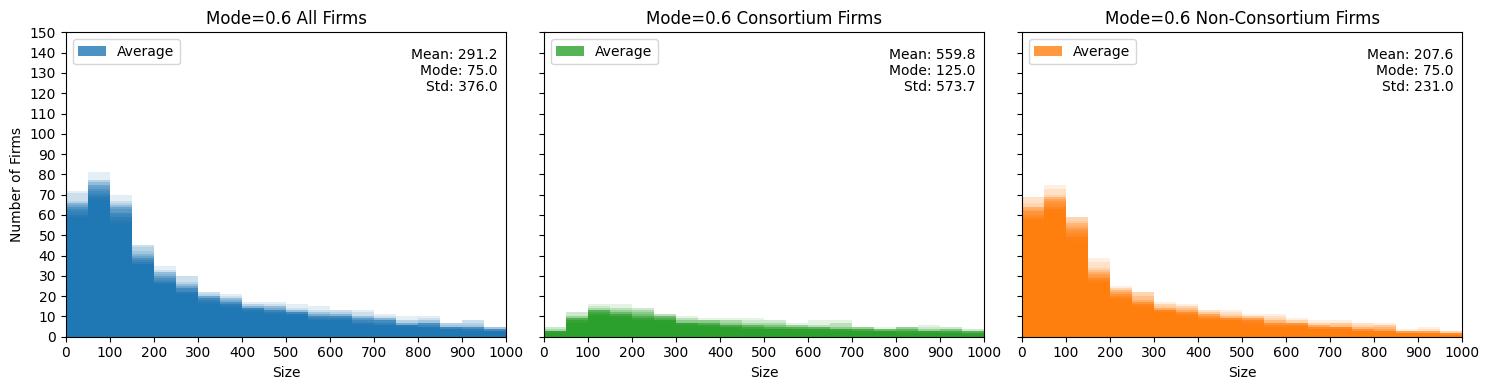

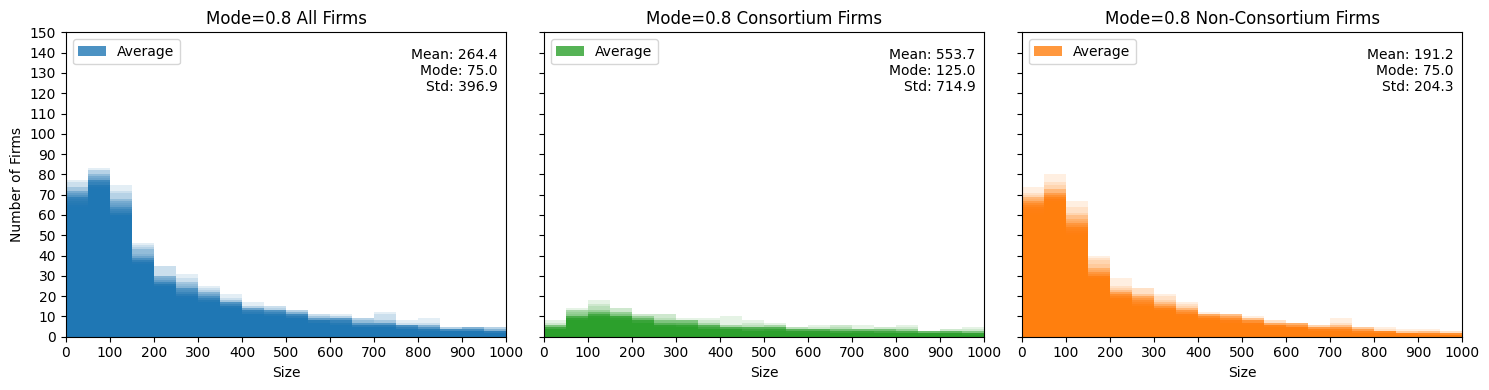

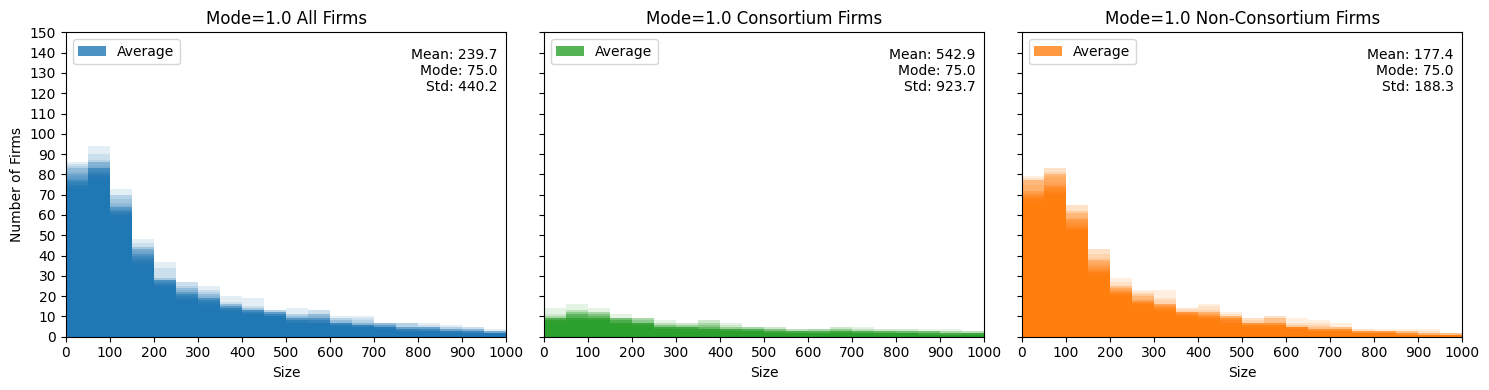

In [ ]:
from analysis.visualize import (
    compute_time_series, plot_time_series, plot_gini_coefficients,
    plot_avg_size_histograms, plot_size_histograms_all_runs_fixed_axes
)
import numpy as np
import matplotlib.pyplot as plt

turns = np.arange(0, 101)  # PARAMS['TURNS'] + 1

# ① 企業数推移（総計も追加）
mode_data_cons = []
mode_data_non = []
mode_data_total = []
modes = np.arange(0, 1.01, 0.2)

for mode in modes:
    dat_cons, dat_non = compute_time_series(mode, return_size_sum=False)
    mode_data_cons.append(dat_cons)
    mode_data_non.append(dat_non)
    mode_data_total.append(dat_cons + dat_non)

colors = plt.cm.viridis(np.linspace(0, 1, len(modes)))

plt.figure(figsize=(10,7))
for i, mode in enumerate(modes):
    plt.plot(turns, mode_data_cons[i], '-', color=colors[i], label=f"{mode:.1f} Con")
    plt.plot(turns, mode_data_non[i], '--', color=colors[i], label=f"{mode:.1f} Non-Con")
    plt.plot(turns, mode_data_total[i], ':', color=colors[i], label=f"{mode:.1f} Total")
plt.xlabel('Turn')
plt.ylabel('Number of Firms')
plt.title('Consortium / Non-Consortium / Total Firms Over Time')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# ② 企業サイズ合計推移（総計も追加）
mode_data_cons_size = []
mode_data_non_size = []
mode_data_total_size = []

for mode in modes:
    dat_cons_size, dat_non_size = compute_time_series(mode, return_size_sum=True)
    mode_data_cons_size.append(dat_cons_size)
    mode_data_non_size.append(dat_non_size)
    mode_data_total_size.append(dat_cons_size + dat_non_size)

plt.figure(figsize=(10,7))
for i, mode in enumerate(modes):
    plt.plot(turns, mode_data_cons_size[i], '-', color=colors[i], label=f"{mode:.1f} Con")
    plt.plot(turns, mode_data_non_size[i], '--', color=colors[i], label=f"{mode:.1f} Non-Con")
    plt.plot(turns, mode_data_total_size[i], ':', color=colors[i], label=f"{mode:.1f} Total")
plt.xlabel('Turn')
plt.ylabel('Total Size of Firms')
plt.title('Consortium / Non-Consortium / Total Firm Size Over Time')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# ③ Gini係数
plot_gini_coefficients()

# ④ ヒストグラム
plot_avg_size_histograms()
plot_size_histograms_all_runs_fixed_axes()


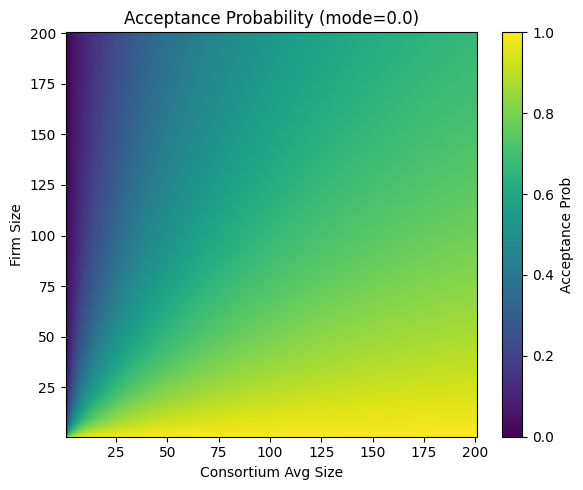

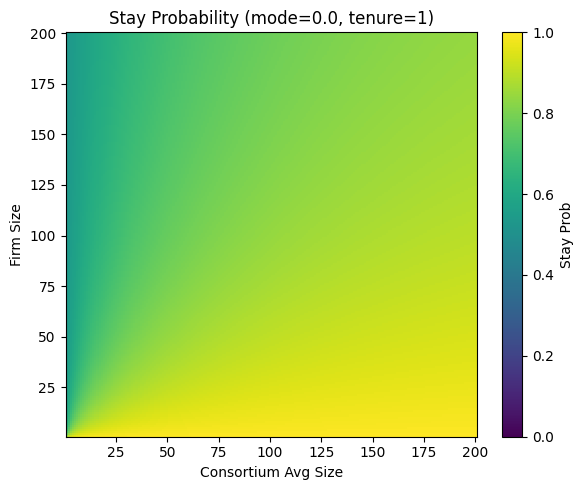

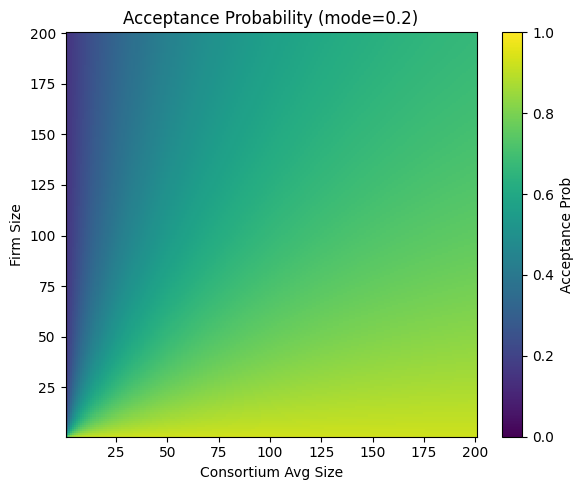

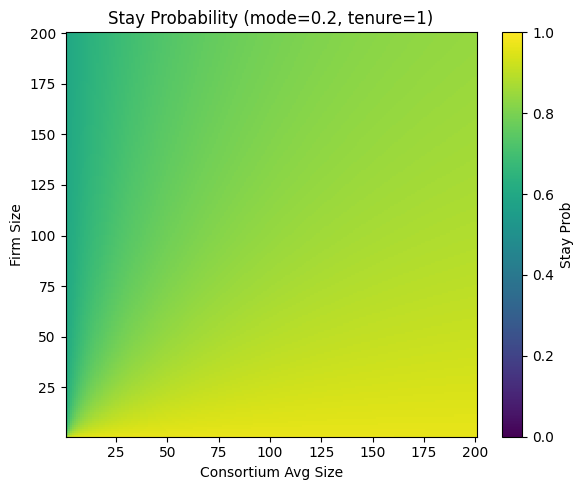

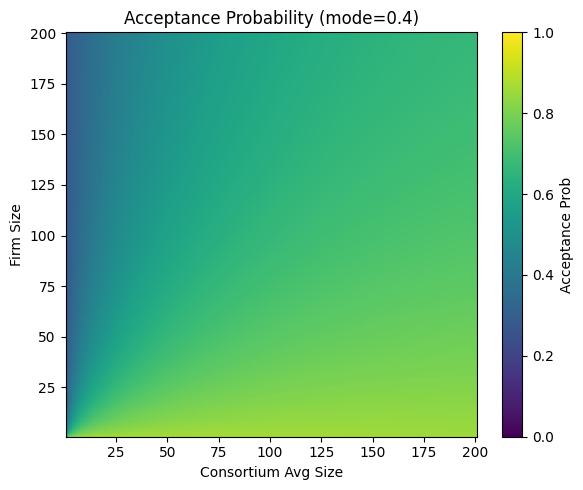

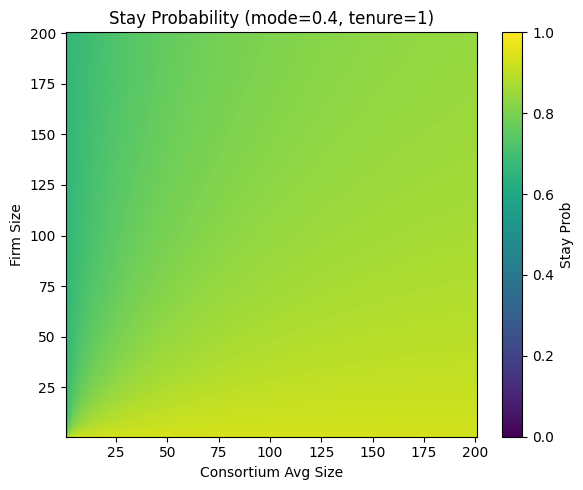

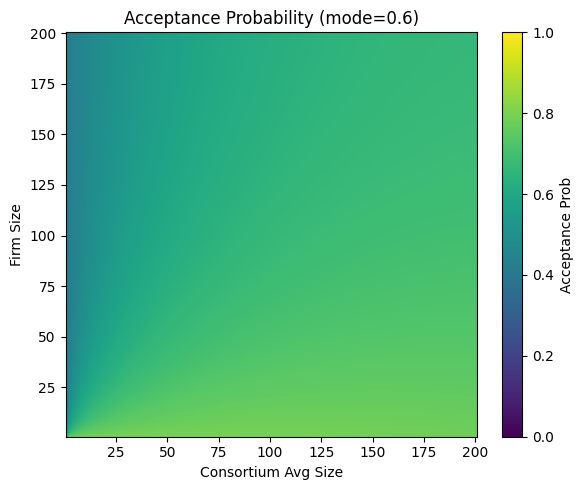

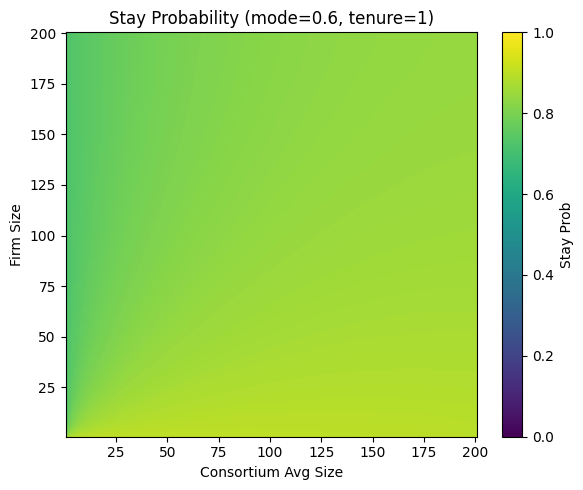

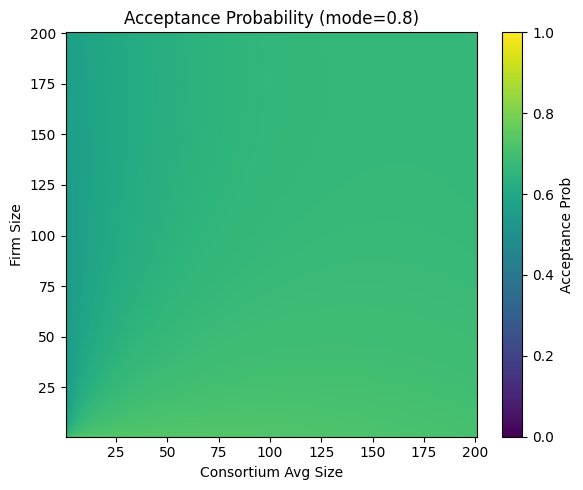

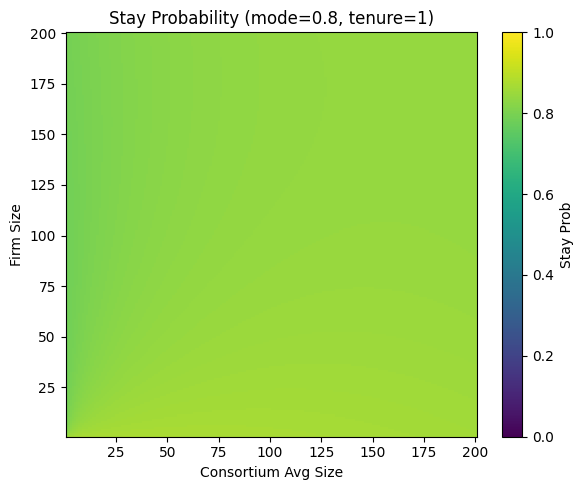

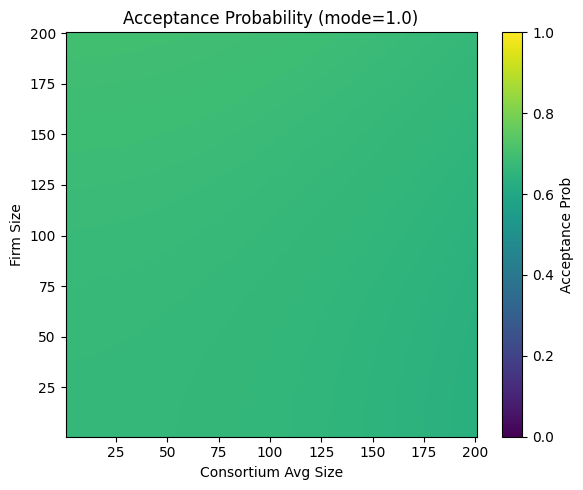

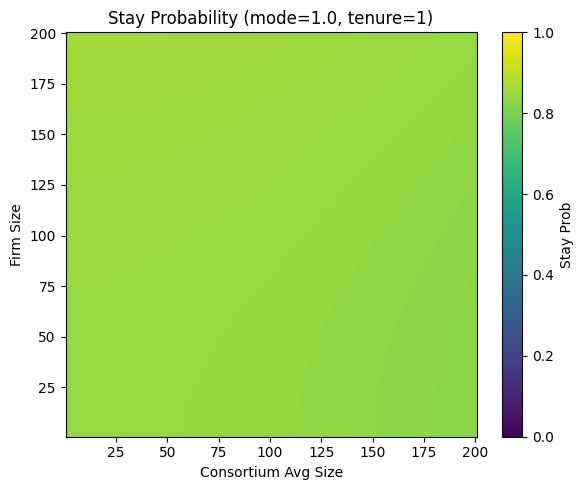

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from config import PARAMS
from model.helpers import p_join_equal, p_join_profit

def p_profit_based(avg, size, mode, params=PARAMS):
    """ 利益ベースの確率関数（加入も脱退も同じ） """
    p_eq = p_join_equal(np.array([avg]), size, params)
    p_pf = p_join_profit(np.array([avg]), size, params)
    return (1 - mode) * p_eq + mode * p_pf

# ヒートマップ用グリッド
avg_sizes = np.linspace(1, 200, 200)
firm_sizes = np.linspace(1, 200, 200)
AVG, SIZE = np.meshgrid(avg_sizes, firm_sizes)

modes = np.arange(0, 1.01, 0.2)

sigma0 = PARAMS.get('INERTIA_STATIC', 0.0)
sigma1 = PARAMS.get('INERTIA_DYNAMIC', 0.0)
tenure = 1  # 今回は在籍年数1で

for mode in modes:
    P_JOIN = np.zeros_like(AVG)
    P_LEAVE = np.zeros_like(AVG)
    P_STAY = np.zeros_like(AVG)
    for i in range(AVG.shape[0]):
        for j in range(AVG.shape[1]):
            avg = AVG[i, j]
            size = SIZE[i, j]
            # 利益比較で加入意向を計算
            p = p_profit_based(avg, size, mode)
            P_JOIN[i, j] = p
            # 脱退確率・残留確率（run_simulation_npと同じロジック！）
            p_leave = (1 - p) / (1 + sigma0 + sigma1 * tenure)
            P_LEAVE[i, j] = p_leave
            P_STAY[i, j] = 1 - p_leave

    # 加入意向ヒートマップ
    fig, ax = plt.subplots(figsize=(6, 5))
    c1 = ax.pcolormesh(AVG, SIZE, P_JOIN, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax.set(xlabel='Consortium Avg Size', ylabel='Firm Size',
           title=f'Acceptance Probability (mode={mode:.1f})')
    fig.colorbar(c1, ax=ax, label='Acceptance Prob')
    plt.tight_layout()
    plt.show()

    # 残留意向ヒートマップ
    fig, ax = plt.subplots(figsize=(6, 5))
    c2 = ax.pcolormesh(AVG, SIZE, P_STAY, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax.set(xlabel='Consortium Avg Size', ylabel='Firm Size',
           title=f'Stay Probability (mode={mode:.1f}, tenure={tenure})')
    fig.colorbar(c2, ax=ax, label='Stay Prob')
    plt.tight_layout()
    plt.show()


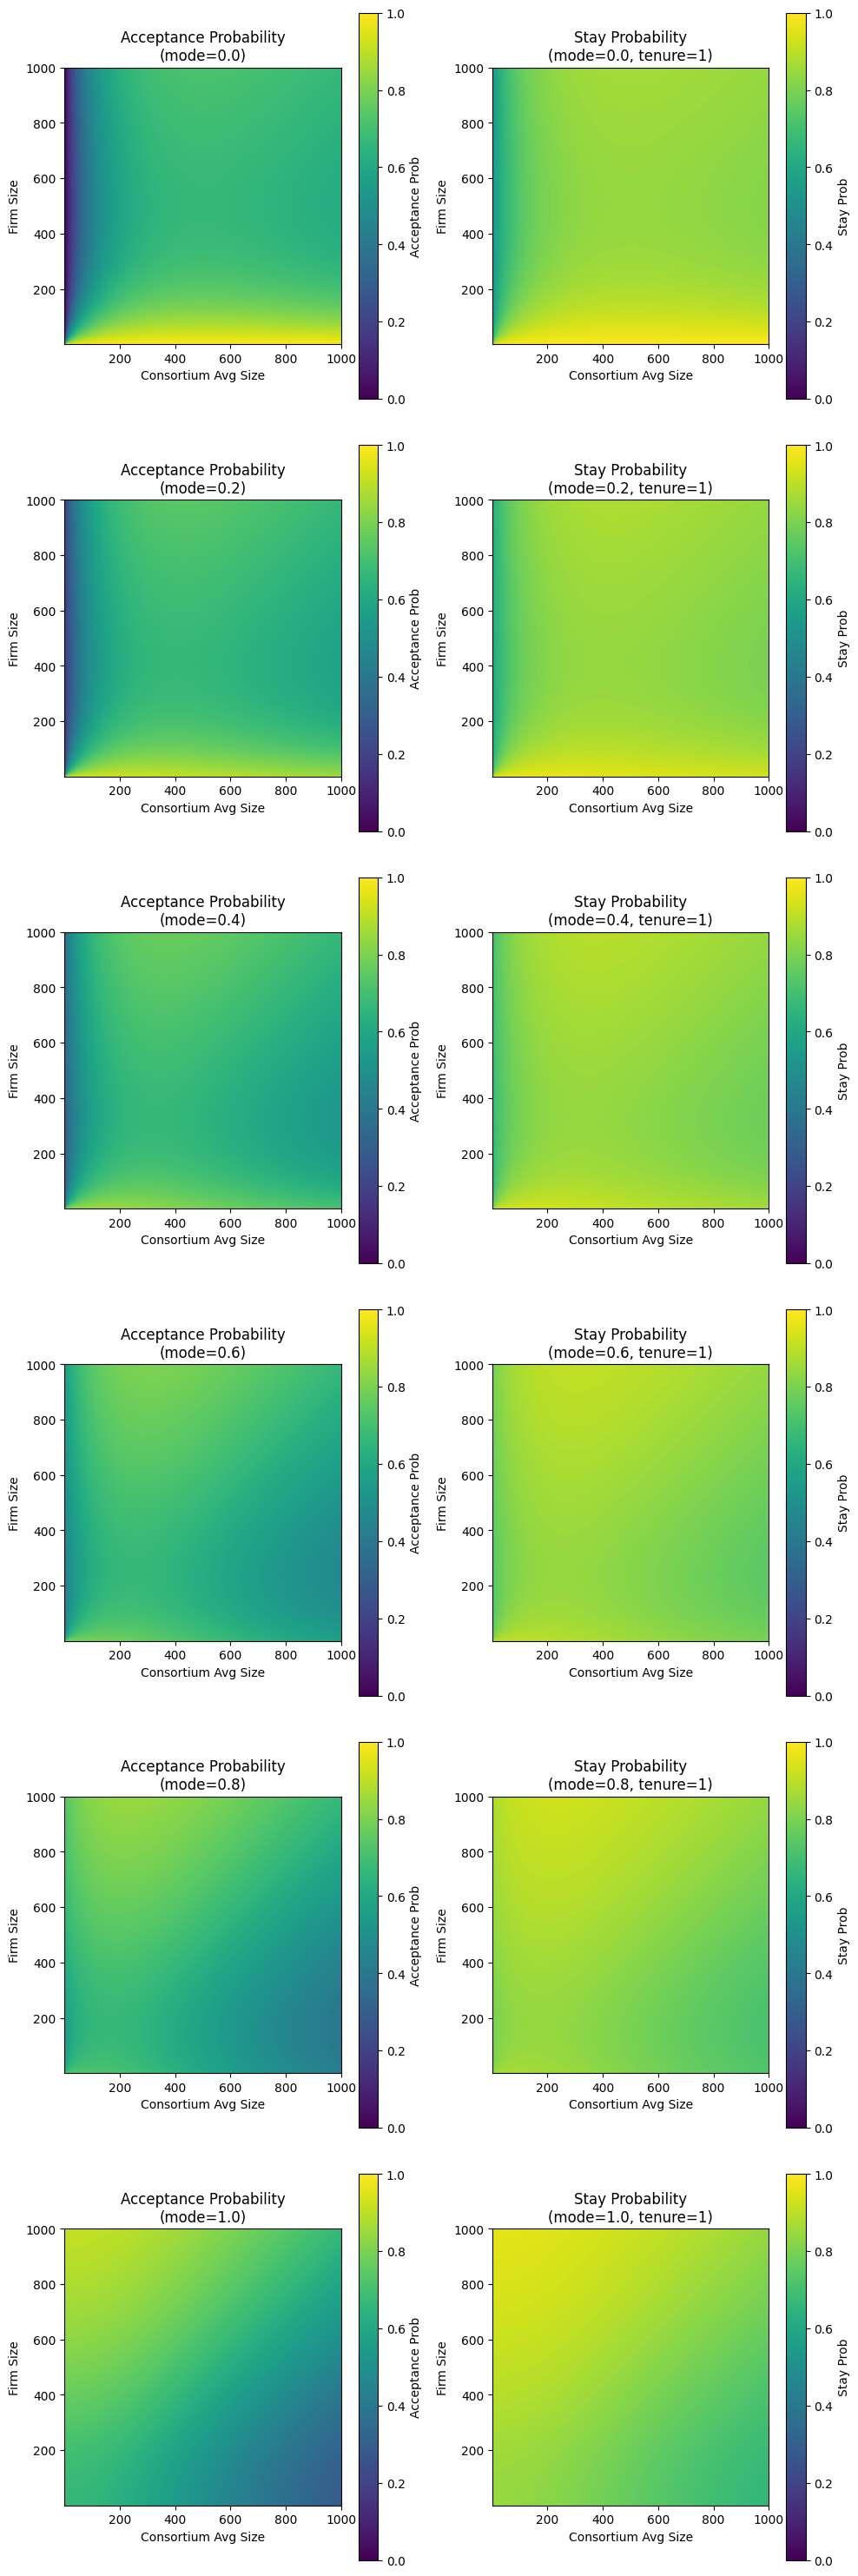

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from config import PARAMS
from model.helpers import p_join_equal, p_join_profit

def p_profit_based(avg, size, mode, params=PARAMS):
    p_eq = p_join_equal(np.array([avg]), size, params)
    p_pf = p_join_profit(np.array([avg]), size, params)
    return (1 - mode) * p_eq + mode * p_pf

avg_sizes = np.linspace(1, 1000, 1000)
firm_sizes = np.linspace(1, 1000, 1000)
AVG, SIZE = np.meshgrid(avg_sizes, firm_sizes)

modes = np.arange(0, 1.01, 0.2)

sigma0 = PARAMS.get('INERTIA_STATIC', 0.0)
sigma1 = PARAMS.get('INERTIA_DYNAMIC', 0.0)
tenure = 1

# 各プロットを正方形にしたいので、figsizeを十分大きく正方形に
fig, axes = plt.subplots(nrows=len(modes), ncols=2, figsize=(10, 5 * len(modes)))

for idx, mode in enumerate(modes):
    P_JOIN = np.zeros_like(AVG)
    P_STAY = np.zeros_like(AVG)
    for i in range(AVG.shape[0]):
        for j in range(AVG.shape[1]):
            avg = AVG[i, j]
            size = SIZE[i, j]
            p = p_profit_based(avg, size, mode)
            P_JOIN[i, j] = p
            p_leave = (1 - p) / (1 + sigma0 + sigma1 * tenure)
            P_STAY[i, j] = 1 - p_leave

    ax1 = axes[idx, 0]
    c1 = ax1.pcolormesh(AVG, SIZE, P_JOIN, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax1.set_xlabel('Consortium Avg Size')
    ax1.set_ylabel('Firm Size')
    ax1.set_title(f'Acceptance Probability\n(mode={mode:.1f})')
    fig.colorbar(c1, ax=ax1, label='Acceptance Prob')
    ax1.set_aspect('equal')  # ここが重要

    ax2 = axes[idx, 1]
    c2 = ax2.pcolormesh(AVG, SIZE, P_STAY, shading='auto', vmin=0, vmax=1, cmap='viridis')
    ax2.set_xlabel('Consortium Avg Size')
    ax2.set_ylabel('Firm Size')
    ax2.set_title(f'Stay Probability\n(mode={mode:.1f}, tenure={tenure})')
    fig.colorbar(c2, ax=ax2, label='Stay Prob')
    ax2.set_aspect('equal')  # ここが重要

plt.tight_layout()
plt.show()
